In [1]:
from preprocessor import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.feature_extraction.text import  CountVectorizer
from nltk.stem.isri import ISRIStemmer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.stem.arlstem import ARLSTem
from nltk.classify import SklearnClassifier
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.contrib import learn
from CNN import *

In [2]:
print("reading the dataset.....")
data = pd.read_csv('../data/datasets/combined_dataset.csv', encoding = "utf-8")
data = data[['class','tweet']]
data = data.reindex(np.random.permutation(data.index))
data = data[1:1000]

print("cleaning the dataset....")
data['cleaned_tweet'] = data['tweet'].map(lambda v: clean_sentence(v)[0])
data['cleaned_tweet_text_only'] = data['tweet'].map(lambda v: clean_sentence(v)[1])

print("building features....")
all_document = data['cleaned_tweet']
tfidf_vectorizer = TfidfVectorizer(norm='l2',min_df=0, use_idf=True, smooth_idf=False, sublinear_tf=True, tokenizer=word_tokenize)
tfidf_model = tfidf_vectorizer.fit(all_document)
data['handed_features'] = data['cleaned_tweet'].map(lambda v: featurize(v, tfidf_model))
pos_neg_data = data[data['class'] != 'neutral']
pos_neg_data['label_encoded'] = pos_neg_data['class'].map(encode_class_labels)
print("finish processing...")

reading the dataset.....
cleaning the dataset....
building features....
finish processing...


C:\Users\Mokhtar Ahmed\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
all_tweets_cleaned = list(pos_neg_data["cleaned_tweet_text_only"])

sentences_lengths = [len(x.split()) for x in all_tweets_cleaned]
max_document_len = max(sentences_lengths)
see("max_document_len",max_document_len)

vocab_processor = learn.preprocessing.VocabularyProcessor(max_document_len)
vocab_processor.fit(all_tweets_cleaned)
vocab_size = len(vocab_processor.vocabulary_)
see("datatset vocab_size", vocab_size)

#vocab_dict = vocab_processor.vocabulary_._mapping
#np.array([all_tweets_cleaned[1]])
#test = np.transpose(np.array([all_tweets_cleaned[1]]))
#print(test.shape)
#see("all_tweets_cleaned[1]", test)
#see("sent", list(vocab_processor.transform(test)))



====================== max_document_len==========================
23


====================== datatset vocab_size==========================
3871


In [7]:
embedding_size = 300
learning_rate  = 0.001
discrete_featuers_size = len(pos_neg_data.iloc[0]["handed_features"])
print(discrete_featuers_size)
cnn_model = TextCNN(embedding_size=embedding_size, filter_sizes=[2,3,4], num_classes=2, num_filters=2,
                    vocab_size=vocab_size, sequence_length=max_document_len, discrete_features_size = discrete_featuers_size)

In [8]:
train, test = train_test_split(pos_neg_data, test_size=0.1)
print("training set size = "+ str(len(train)))
print("testing set size = "+ str(len(test)))

training set size = 594
testing set size = 67


In [9]:
def generate_batch_data(train_data, batch_size=10):
    batch_data = train.sample(n=batch_size, replace=False)
    x_train = np.transpose(batch_data["cleaned_tweet_text_only"])
    x_train_features = np.array(list(batch_data["handed_features"]))
    y_train = np.array(list(batch_data["label_encoded"]))
    xi_train = np.array(list(vocab_processor.transform(x_train)))
    #print(xi_train.shape)
    #print(x_train_features.shape)
    #print(y_train.shape)
    return xi_train,x_train_features, y_train

In [ ]:
x = generate_batch_data(train)

In [15]:
def train_step(batch_id, x_batch, y_batch, x_feat, dropout_keep_prob = 0.8):
    feed_dict = {cnn_model.input_x: x_batch,
                 cnn_model.input_y: y_batch,
                 cnn_model.discrete_features: x_feat,
                 cnn_model.dropout_keep_prob: dropout_keep_prob}
    loss, accuracy = sess.run([cnn_model.loss, cnn_model.accuracy],feed_dict)
    print("bacht_no {:g}, loss {:g}, acc {:g}".format(batch_id, loss, accuracy))
    #print(cnn_model.combined_features.shape)
    return loss, accuracy

def dev_step(x_batch, y_batch, x_feat):
    return train_step(1, x_batch, y_batch, x_feat, 1)
                
tf.train.AdamOptimizer(learning_rate).minimize(cnn_model.loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [16]:
iterations = 1000 
batch_size = 200 
evaluate_every = 100 

train_loss = []
train_acc = []
test_loss = []
test_acc = []
ii_data = range(iterations)
i_data = []

for batch_id in ii_data:
    train_shuffled = train.reindex(np.random.permutation(train.index))
    x_batch, x_feat, y_batch = generate_batch_data(train_shuffled, batch_size) 
    loss, accuracy = train_step(batch_id,x_batch,y_batch, x_feat)
    train_loss.append(loss)
    train_acc.append(accuracy)
    
    if(batch_id % evaluate_every == 0):
        print("\n------------- Evaluation -------------------")
        test_shuffled = test.reindex(np.random.permutation(test.index))
        x_dev,x_dev_feat, y_dev = generate_batch_data(test_shuffled, test.shape[0])
        loss, accuracy = dev_step(x_dev,y_dev, x_dev_feat)
        test_loss.append(loss)
        test_acc.append(accuracy)
        i_data.append(batch_id+1)
        print("----------------------------------------------")

bacht_no 0, loss 0.683694, acc 0.56

------------- Evaluation -------------------
bacht_no 1, loss 0.694627, acc 0.462687
----------------------------------------------
bacht_no 1, loss 0.685965, acc 0.555
bacht_no 2, loss 0.689974, acc 0.515
bacht_no 3, loss 0.687269, acc 0.54
bacht_no 4, loss 0.695496, acc 0.52
bacht_no 5, loss 0.69202, acc 0.515
bacht_no 6, loss 0.692997, acc 0.54
bacht_no 7, loss 0.693149, acc 0.54
bacht_no 8, loss 0.695956, acc 0.49
bacht_no 9, loss 0.694306, acc 0.46
bacht_no 10, loss 0.69813, acc 0.475
bacht_no 11, loss 0.691636, acc 0.505
bacht_no 12, loss 0.690156, acc 0.515
bacht_no 13, loss 0.691772, acc 0.56
bacht_no 14, loss 0.686186, acc 0.54
bacht_no 15, loss 0.692397, acc 0.5
bacht_no 16, loss 0.690123, acc 0.525
bacht_no 17, loss 0.693179, acc 0.51
bacht_no 18, loss 0.687948, acc 0.53
bacht_no 19, loss 0.69631, acc 0.495
bacht_no 20, loss 0.691443, acc 0.53
bacht_no 21, loss 0.686033, acc 0.555
bacht_no 22, loss 0.683542, acc 0.57
bacht_no 23, loss 0.6

bacht_no 207, loss 0.687727, acc 0.535
bacht_no 208, loss 0.695405, acc 0.495
bacht_no 209, loss 0.698691, acc 0.505
bacht_no 210, loss 0.690771, acc 0.5
bacht_no 211, loss 0.692017, acc 0.5
bacht_no 212, loss 0.697442, acc 0.485
bacht_no 213, loss 0.69582, acc 0.485
bacht_no 214, loss 0.699647, acc 0.485
bacht_no 215, loss 0.691494, acc 0.52
bacht_no 216, loss 0.698137, acc 0.45
bacht_no 217, loss 0.686537, acc 0.545
bacht_no 218, loss 0.697191, acc 0.495
bacht_no 219, loss 0.693898, acc 0.515
bacht_no 220, loss 0.695605, acc 0.515
bacht_no 221, loss 0.687218, acc 0.565
bacht_no 222, loss 0.687485, acc 0.585
bacht_no 223, loss 0.687392, acc 0.53
bacht_no 224, loss 0.693924, acc 0.52
bacht_no 225, loss 0.689369, acc 0.515
bacht_no 226, loss 0.690123, acc 0.535
bacht_no 227, loss 0.6939, acc 0.515
bacht_no 228, loss 0.69849, acc 0.47
bacht_no 229, loss 0.694611, acc 0.515
bacht_no 230, loss 0.688084, acc 0.535
bacht_no 231, loss 0.685839, acc 0.56
bacht_no 232, loss 0.693775, acc 0.52
b

bacht_no 416, loss 0.693844, acc 0.535
bacht_no 417, loss 0.694652, acc 0.5
bacht_no 418, loss 0.691142, acc 0.52
bacht_no 419, loss 0.690732, acc 0.5
bacht_no 420, loss 0.702134, acc 0.47
bacht_no 421, loss 0.693781, acc 0.54
bacht_no 422, loss 0.693756, acc 0.51
bacht_no 423, loss 0.677383, acc 0.59
bacht_no 424, loss 0.691134, acc 0.515
bacht_no 425, loss 0.681678, acc 0.535
bacht_no 426, loss 0.691002, acc 0.535
bacht_no 427, loss 0.6985, acc 0.5
bacht_no 428, loss 0.681145, acc 0.555
bacht_no 429, loss 0.692009, acc 0.525
bacht_no 430, loss 0.685624, acc 0.55
bacht_no 431, loss 0.692241, acc 0.495
bacht_no 432, loss 0.698264, acc 0.475
bacht_no 433, loss 0.692947, acc 0.51
bacht_no 434, loss 0.692252, acc 0.535
bacht_no 435, loss 0.693665, acc 0.52
bacht_no 436, loss 0.685402, acc 0.57
bacht_no 437, loss 0.683113, acc 0.56
bacht_no 438, loss 0.697608, acc 0.455
bacht_no 439, loss 0.693259, acc 0.505
bacht_no 440, loss 0.690529, acc 0.53
bacht_no 441, loss 0.696887, acc 0.49
bacht_

bacht_no 623, loss 0.689036, acc 0.535
bacht_no 624, loss 0.685001, acc 0.57
bacht_no 625, loss 0.684871, acc 0.56
bacht_no 626, loss 0.692073, acc 0.52
bacht_no 627, loss 0.694776, acc 0.51
bacht_no 628, loss 0.700467, acc 0.515
bacht_no 629, loss 0.694625, acc 0.48
bacht_no 630, loss 0.678897, acc 0.585
bacht_no 631, loss 0.698303, acc 0.525
bacht_no 632, loss 0.691017, acc 0.485
bacht_no 633, loss 0.699094, acc 0.45
bacht_no 634, loss 0.685936, acc 0.575
bacht_no 635, loss 0.688928, acc 0.53
bacht_no 636, loss 0.685383, acc 0.535
bacht_no 637, loss 0.692435, acc 0.535
bacht_no 638, loss 0.69446, acc 0.49
bacht_no 639, loss 0.701716, acc 0.48
bacht_no 640, loss 0.701858, acc 0.52
bacht_no 641, loss 0.694587, acc 0.505
bacht_no 642, loss 0.69344, acc 0.505
bacht_no 643, loss 0.689539, acc 0.545
bacht_no 644, loss 0.688095, acc 0.53
bacht_no 645, loss 0.697775, acc 0.495
bacht_no 646, loss 0.685693, acc 0.575
bacht_no 647, loss 0.68601, acc 0.555
bacht_no 648, loss 0.696314, acc 0.505


bacht_no 830, loss 0.693009, acc 0.525
bacht_no 831, loss 0.697983, acc 0.51
bacht_no 832, loss 0.699323, acc 0.48
bacht_no 833, loss 0.696989, acc 0.5
bacht_no 834, loss 0.69882, acc 0.5
bacht_no 835, loss 0.69053, acc 0.535
bacht_no 836, loss 0.692319, acc 0.535
bacht_no 837, loss 0.689095, acc 0.5
bacht_no 838, loss 0.69666, acc 0.515
bacht_no 839, loss 0.689221, acc 0.525
bacht_no 840, loss 0.688959, acc 0.56
bacht_no 841, loss 0.689973, acc 0.48
bacht_no 842, loss 0.691152, acc 0.495
bacht_no 843, loss 0.684703, acc 0.565
bacht_no 844, loss 0.695257, acc 0.515
bacht_no 845, loss 0.688091, acc 0.535
bacht_no 846, loss 0.688493, acc 0.525
bacht_no 847, loss 0.688024, acc 0.525
bacht_no 848, loss 0.687455, acc 0.565
bacht_no 849, loss 0.689321, acc 0.545
bacht_no 850, loss 0.687299, acc 0.535
bacht_no 851, loss 0.691256, acc 0.525
bacht_no 852, loss 0.696154, acc 0.51
bacht_no 853, loss 0.687353, acc 0.58
bacht_no 854, loss 0.689265, acc 0.57
bacht_no 855, loss 0.695715, acc 0.52
bac

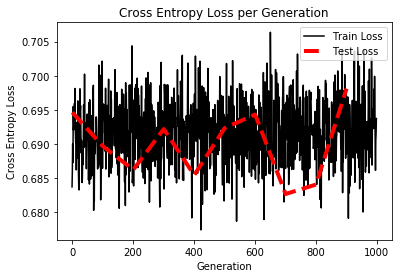

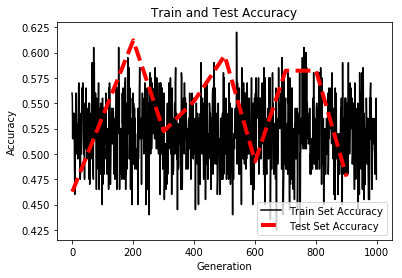

In [18]:
# Plot loss over time
plt.plot(ii_data, train_loss, 'k-', label='Train Loss')
plt.plot(i_data, test_loss, 'r--', label='Test Loss', linewidth=4)
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.legend(loc='upper right')
plt.show()

# Plot train and test accuracy
plt.plot(ii_data, train_acc, 'k-', label='Train Set Accuracy')
plt.plot(i_data, test_acc, 'r--', label='Test Set Accuracy', linewidth=4)
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()